# Entrega 2 - Aprendizaje No Supervisado


# Contexto

Se va a utilizar un conjunto de datos sobre **datos de clientes** con sus características para crear un modelo de aprendizaje automático.

# Contenido del fichero

Los datos contienen un histórico basado en
ventas y con las siguientes variables:

- ID: corresponde con el ID del cliente dado por la compañía.
- Sexo: sexo del cliente.
- Edad: edad del cliente.
- Ingresos: ingresos declarados por el cliente.
- Score: es una puntuación dada por la compañía en base al comportamiento de compra del cliente.

# IMPORTAR PAQUETES

In [1]:
# pip install pyjanitor

In [1]:
import numpy as np
import pandas as pd
from janitor import clean_names

#Automcompletar rápido
%config IPCompleter.greedy=True

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## IMPORTAR LOS DATOS

Cargar los datos. Debido a que el dataset de clientes usa como delimitador **"punto y coma"** (en lugar del default "coma"), se debe de especificar a Pandas que utilice este como delimitador, para poder procesar el fichero

In [5]:
df = pd.read_csv('clientes.csv',index_col=0, delimiter=';')
df.head()

,Sexo,Edad,Ingresos,Score
ID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## CORRECCIÓN DE NOMBRES DE VARIABLES

### Corrección automática

In [6]:
df = clean_names(df)
df

,sexo,edad,ingresos,score
ID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


# VISIÓN GENERAL

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sexo      200 non-null    object
 1   edad      200 non-null    int64 
 2   ingresos  200 non-null    int64 
 3   score     200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


## TIPOS DE DATOS

### Identificación

In [8]:
df.dtypes

sexo        object
edad         int64
ingresos     int64
score        int64
dtype: object

## VALORES ÚNICOS

### Identificación

In [10]:
df.nunique().sort_values()

sexo         2
edad        51
ingresos    64
score       84
dtype: int64

## DUPLICADOS

### Identificación

In [11]:
df.duplicated().sum()

0

## SEPARAR NUMÉRICAS Y CATEGÓRICAS

### Categóricas

In [12]:
cat = df.select_dtypes(exclude = 'number').copy()

### Numéricas

In [13]:
num = df.select_dtypes(include='number').copy()

## GESTIÓN DE CATEGÓRICAS

### Nulos

#### Identificación

In [14]:
cat.isna().sum().sort_values(ascending = False)

sexo    0
dtype: int64

## GESTIÓN DE NUMÉRICAS

### Nulos

#### Identificación

In [15]:
num.isna().sum().sort_values(ascending = False)

edad        0
ingresos    0
score       0
dtype: int64

### Atípicos

#### Por desviación típica

##### Identificación

###### Definir el número de desviaciones típicas

In [16]:
num_desv_tip = 4

###### Función que devuelve los índices de los atípicos

In [17]:
def atipicos_desv_tip(variable, num_desv_tip = 4):
    #sacamos los nulos por ahora
    variable = variable.dropna()
    #calculamos los límites
    media = np.mean(variable)
    sd = np.std(variable)
    umbral = sd * num_desv_tip
    lim_inf = media - umbral
    lim_sup = media + umbral
    #encontramos los índices de los que están fuera de los límites
    indices = [indice for indice,valor in variable.items() if valor < lim_inf or valor > lim_sup]
    return(indices)

###### Función que cuenta el número de atípicos

In [18]:
df.shape[0]

200

In [19]:
def conteo_atipicos(df,variable, num_desv_tip = 4):
    atipicos = atipicos_desv_tip(df[variable], num_desv_tip)
    print('% de Observaciones fuera de límites: ',len(atipicos)/df.shape[0]*100)
    return(df.loc[atipicos,variable].value_counts())

###### Variables a aplicar

In [21]:
var_atipicos_dt = ['edad','ingresos','score']

###### Aplicar

In [22]:
for variable in var_atipicos_dt:
    print('\n' + variable + ':\n')
    print(conteo_atipicos(num,variable,num_desv_tip))


edad:

% de Observaciones fuera de límites:  0.0
Series([], Name: edad, dtype: int64)

ingresos:

% de Observaciones fuera de límites:  0.0
Series([], Name: ingresos, dtype: int64)

score:

% de Observaciones fuera de límites:  0.0
Series([], Name: score, dtype: int64)


# EDA

## EDA CATEGÓRICAS

### Análisis estadístico

In [23]:
def frecuencias_cat(df_cat):
    resultado = df_cat.apply(lambda x: x.value_counts()).T.stack()\
                .to_frame().reset_index()\
                .rename(columns={'level_0':'Variable','level_1':'Valor',0: "Frecuencia"})\
                .sort_values(by = ['Variable','Frecuencia'])
    return(resultado)

In [24]:
frecuencias_cat(cat)

,Variable,Valor,Frecuencia
1,sexo,Male,88
0,sexo,Female,112


### Análisis gráfico

In [40]:
def graficos_eda_categoricos(cat):
    
    #Calculamos el número de filas que necesitamos
    from math import ceil
    filas = 2

    #Definimos el gráfico
    f, ax = plt.subplots(nrows = filas, ncols = 1, figsize = (16, filas * 6))

    #Aplanamos para iterar por el gráfico como si fuera de 1 dimensión en lugar de 2
    ax = ax.flat 

    #Creamos el bucle que va añadiendo gráficos
    for cada, variable in enumerate(cat):
        cat[variable].value_counts().plot.barh(ax = ax[cada])
        ax[cada].set_title(variable, fontsize = 12, fontweight = "bold")
        ax[cada].tick_params(labelsize = 12)

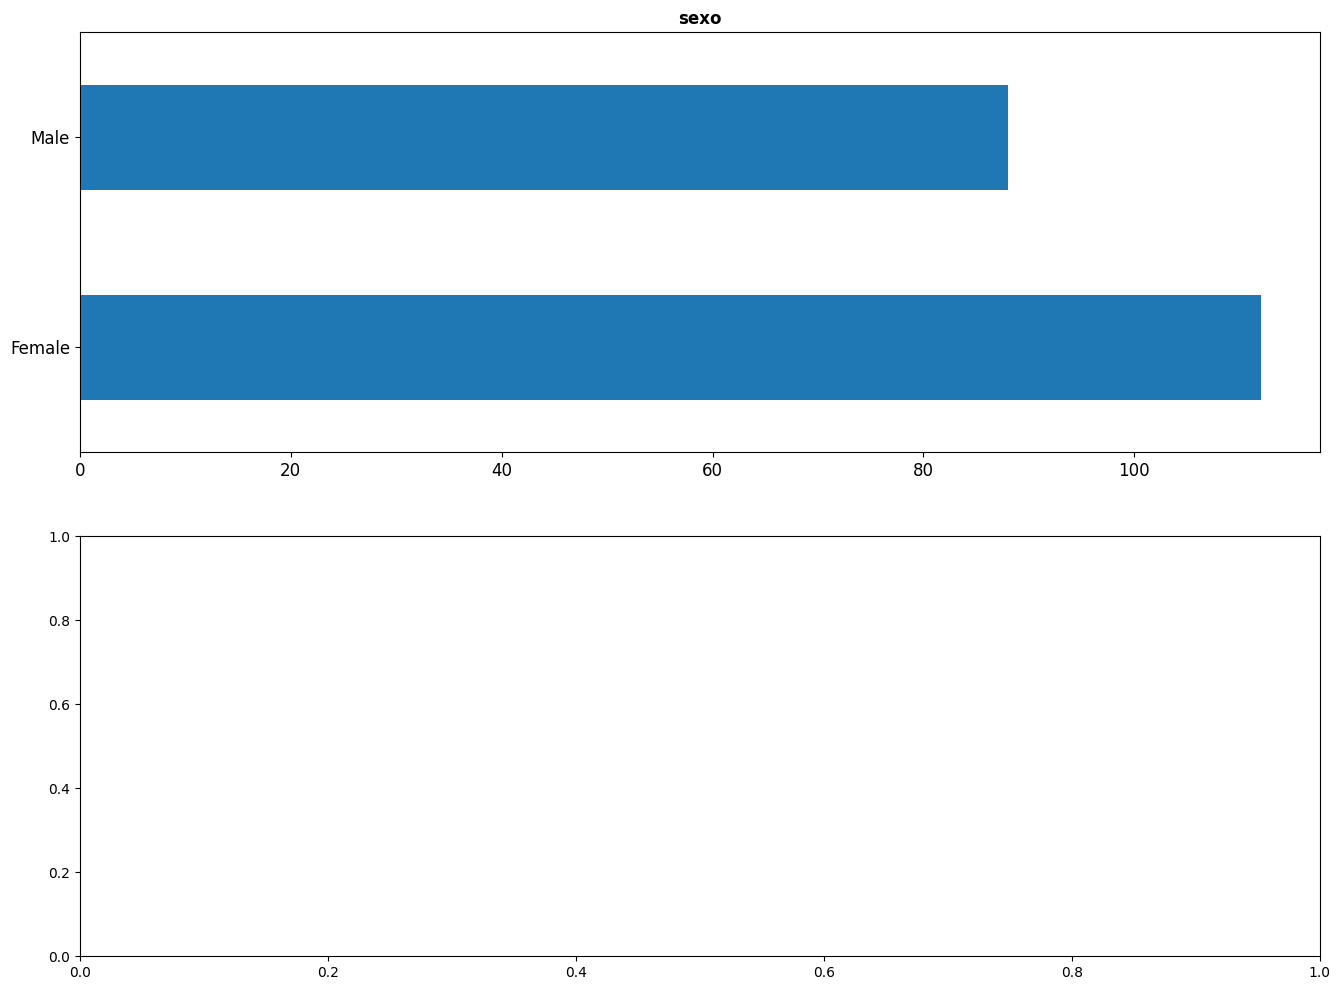

In [41]:
graficos_eda_categoricos(cat[['sexo']])

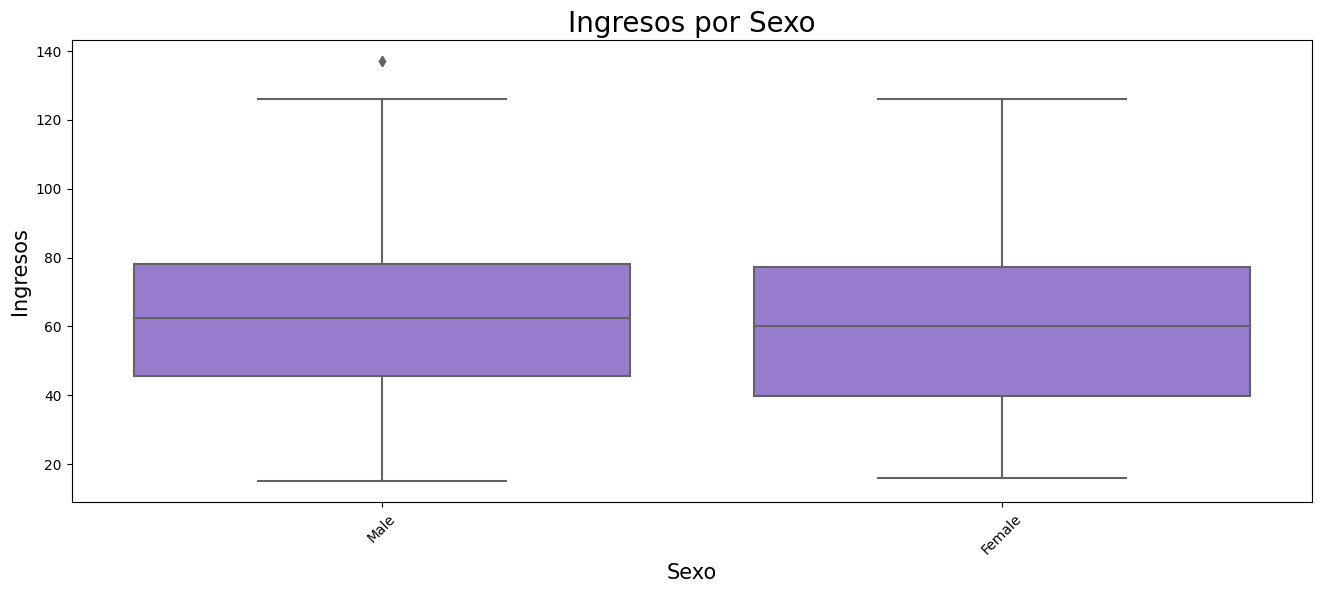

In [42]:
plt.figure(figsize=(16,6))

graph = sns.boxplot(x='sexo', y='ingresos',
                 data=df,
                 color='mediumpurple')
graph.set_title("Ingresos por Sexo", fontsize=20)
graph.set_xlabel("Sexo", fontsize=15)
graph.tick_params(axis='x', rotation=45)
graph.set_ylabel("Ingresos", fontsize=15)
graph.set_xticklabels(graph.get_xticklabels())

plt.show()

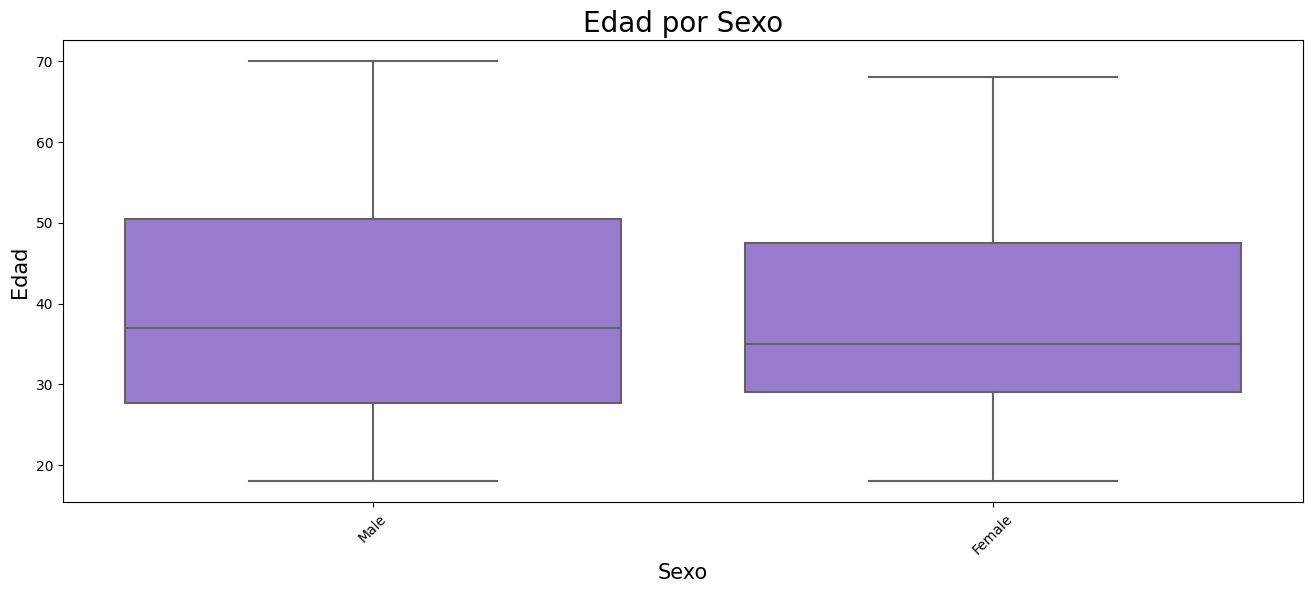

In [46]:
plt.figure(figsize=(16,6))

graph = sns.boxplot(x='sexo', y='edad',
                 data=df,
                 color='mediumpurple')
graph.set_title("Edad por Sexo", fontsize=20)
graph.set_xlabel("Sexo", fontsize=15)
graph.tick_params(axis='x', rotation=45)
graph.set_ylabel("Edad", fontsize=15)
graph.set_xticklabels(graph.get_xticklabels())

plt.show()

## EDA NUMÉRICAS

### Análisis estadístico

In [47]:
def estadisticos_cont(num):
    #Calculamos describe
    estadisticos = num.describe().T
    #Añadimos la mediana
    estadisticos['median'] = num.median()
    #Reordenamos para que la mediana esté al lado de la media
    estadisticos = estadisticos.iloc[:,[0,1,8,2,3,4,5,6,7]]
    #Lo devolvemos
    return(estadisticos)

In [48]:
estadisticos_cont(num)

,count,mean,median,std,min,25%,50%,75%,max
edad,200.0,38.85,36.0,13.969007,18.0,28.75,36.0,49.0,70.0
ingresos,200.0,60.56,61.5,26.264721,15.0,41.50,61.5,78.0,137.0
score,200.0,50.20,50.0,25.823522,1.0,34.75,50.0,73.0,99.0


### Análisis gráfico

In [49]:
def graficos_eda_continuas(num):
    
    #Calculamos el número de fila que necesitamos
    from math import ceil
    filas = ceil(num.shape[1] / 2)

    #Definimos el gráfico
    f, ax = plt.subplots(nrows = filas, ncols = 2, figsize = (16, filas * 6))

    #Aplanamos para iterar por el gráfico como si fuera de 1 dimensión en lugar de 2
    ax = ax.flat 

    #Creamos el bucle que va añadiendo gráficos
    for cada, variable in enumerate(num):
        num[variable].plot.density(ax = ax[cada])
        ax[cada].set_title(variable, fontsize = 12, fontweight = "bold")
        ax[cada].tick_params(labelsize = 12)

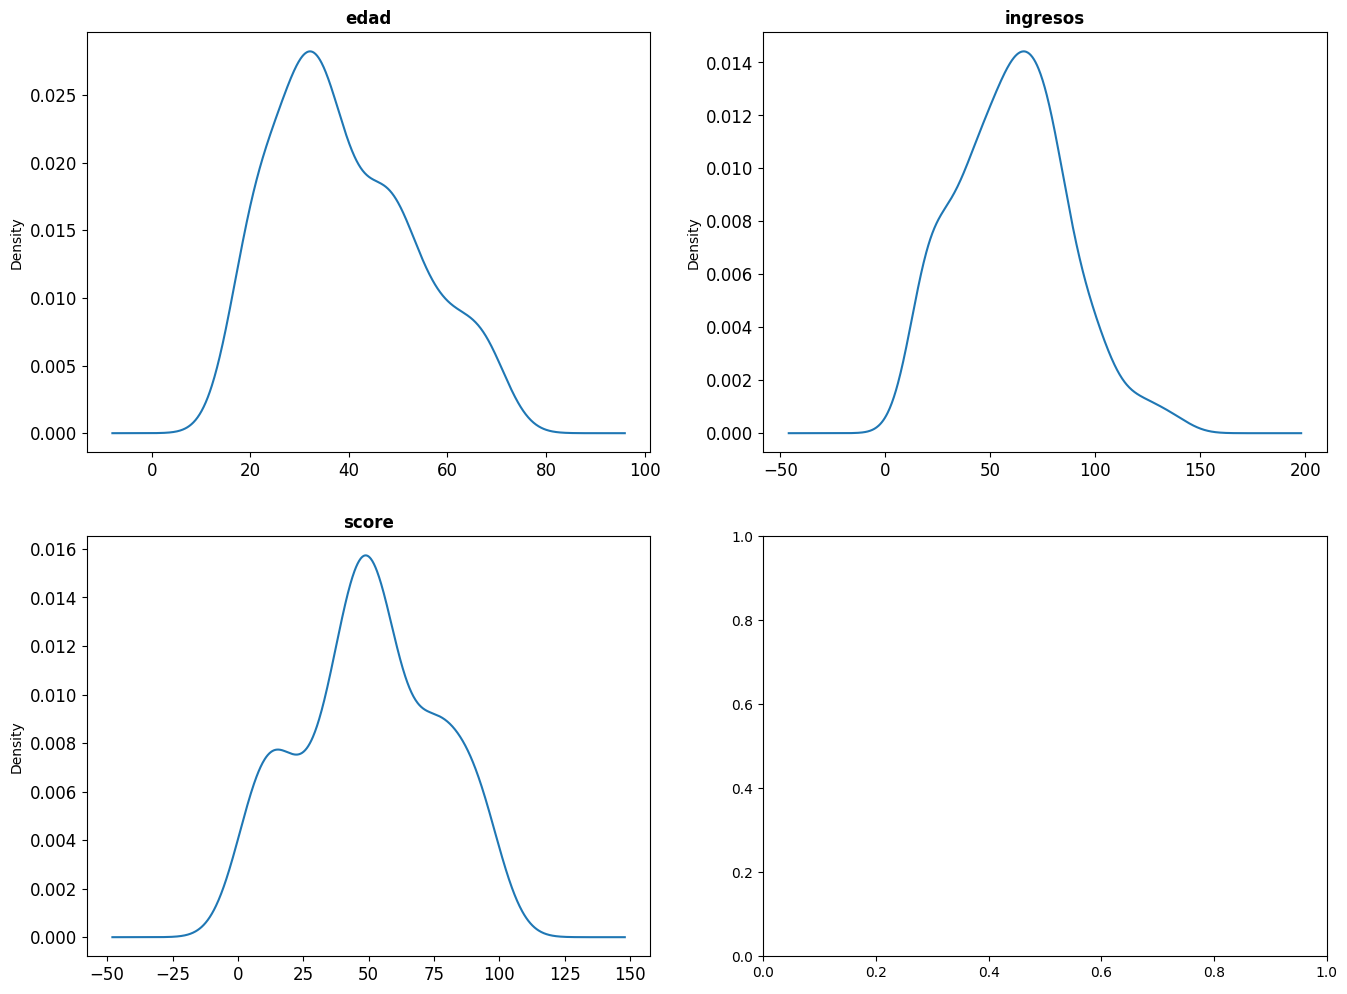

In [50]:
graficos_eda_continuas(num[['edad', 'ingresos', 'score']])

### Selección y guardar en dataframe

In [52]:
df[df.ingresos >= 100].count()

sexo        14
edad        14
ingresos    14
score       14
dtype: int64

% muy bajos de atípicos, eliminamos aquellos ingresos muy altos con baja frecuencia.

In [54]:
df = df[df.ingresos < 100]

# generamos de nuevo los df cat y num

cat = df.select_dtypes(exclude = 'number').copy()

num = df.select_dtypes(include='number').copy()

In [55]:
estadisticos_cont(num)

,count,mean,median,std,min,25%,50%,75%,max
edad,186.0,38.994624,36.0,14.345353,18.0,28.0,36.0,49.0,70.0
ingresos,186.0,56.483871,60.0,22.165770,15.0,40.0,60.0,74.0,99.0
score,186.0,50.306452,50.0,25.434126,1.0,35.0,50.0,72.0,99.0


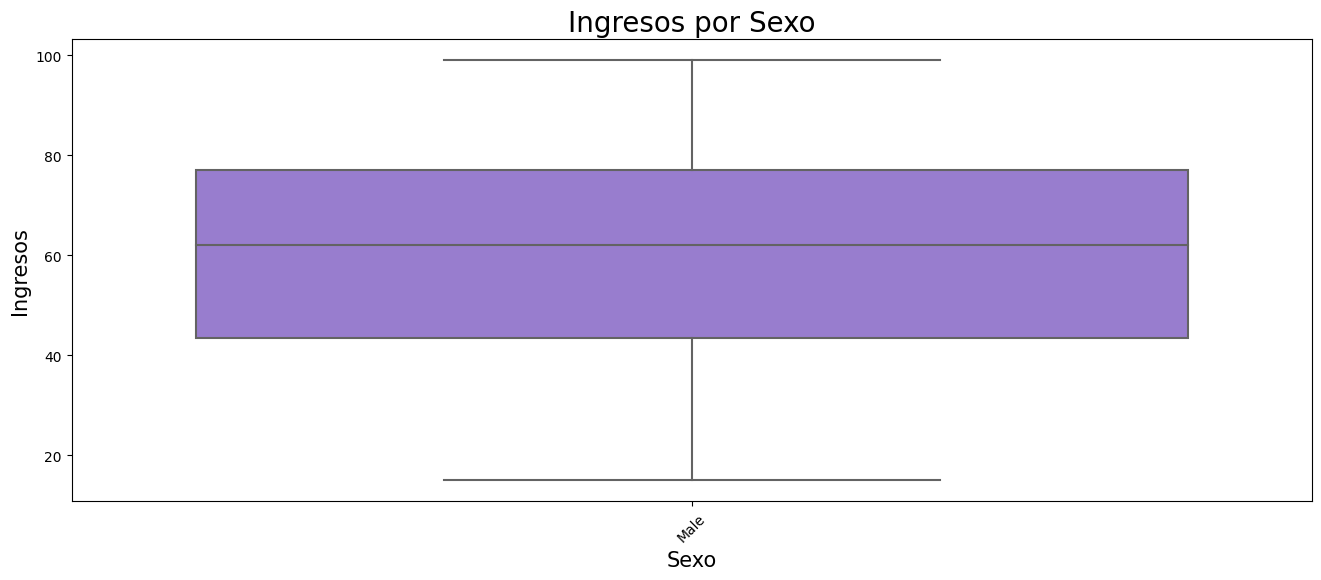

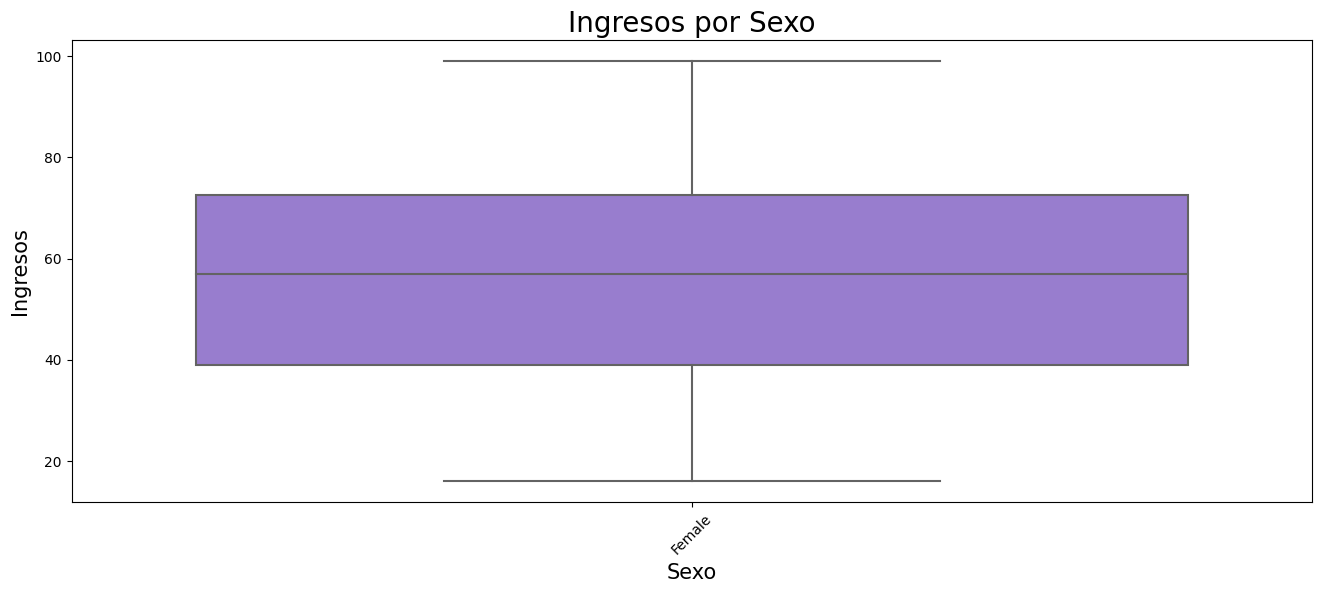

In [56]:
genero=['Male','Female']

for g in genero:
    
    df1 = df.loc[df['sexo'] == g,['sexo','ingresos']]
    plt.figure(figsize=(16,6))

    graph = sns.boxplot(x='sexo', y='ingresos',
                     data=df1,
                     color='mediumpurple')
    graph.set_title("Ingresos por Sexo", fontsize=20)
    graph.set_xlabel("Sexo", fontsize=15)
    graph.tick_params(axis='x', rotation=45)
    graph.set_ylabel("Ingresos", fontsize=15)
    graph.set_xticklabels(graph.get_xticklabels())

plt.show()

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 1 to 186
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sexo      186 non-null    object
 1   edad      186 non-null    int64 
 2   ingresos  186 non-null    int64 
 3   score     186 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.3+ KB


# TRANSFORMACIÓN DE DATOS

In [58]:
df.head()

,sexo,edad,ingresos,score
ID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


### One Hot Encoding

#### Variables a aplicar OHE

In [59]:
var_ohe = ['sexo']

#### Instanciar

In [60]:
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')

#### Entrenar y aplicar

In [61]:
cat_ohe = ohe.fit_transform(cat[var_ohe])

/home/victorpacheco/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Guardar como dataframe

In [62]:
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out())
cat_ohe.head()

,sexo_Female,sexo_Male
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


## REESCALAR VARIABLES

### Con Min-Max

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 1 to 186
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sexo      186 non-null    object
 1   edad      186 non-null    int64 
 2   ingresos  186 non-null    int64 
 3   score     186 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.3+ KB


#### Variables a reescalar con Min-Max

In [65]:
var_mms = ['edad','ingresos','score']

In [66]:
df[df.score.isna()]

,sexo,edad,ingresos,score
ID,,,,


#### Instanciar

In [67]:
# escala entre 0 y 1

mms = MinMaxScaler()

#### Entrenar y aplicar

In [68]:
df_mms = mms.fit_transform(df[var_mms])

#### Guardar como dataframe

In [69]:
#Añadir sufijos a los nombres
nombres_mms = [variable + '_mms' for variable in var_mms]

#Guardar como dataframe
df_mms = pd.DataFrame(df_mms,columns = nombres_mms)

In [70]:
df = pd.concat([df,cat_ohe,df_mms], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 1 to 0
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sexo          186 non-null    object 
 1   edad          186 non-null    float64
 2   ingresos      186 non-null    float64
 3   score         186 non-null    float64
 4   sexo_Female   186 non-null    float64
 5   sexo_Male     186 non-null    float64
 6   edad_mms      186 non-null    float64
 7   ingresos_mms  186 non-null    float64
 8   score_mms     186 non-null    float64
dtypes: float64(8), object(1)
memory usage: 14.6+ KB


In [71]:
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185 entries, 1 to 185
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sexo          185 non-null    object 
 1   edad          185 non-null    float64
 2   ingresos      185 non-null    float64
 3   score         185 non-null    float64
 4   sexo_Female   185 non-null    float64
 5   sexo_Male     185 non-null    float64
 6   edad_mms      185 non-null    float64
 7   ingresos_mms  185 non-null    float64
 8   score_mms     185 non-null    float64
dtypes: float64(8), object(1)
memory usage: 14.5+ KB


# MODELIZACIÓN PARA NO SUPERVISADO

## IMPORTAR PAQUETES

In [72]:

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

from sklearn.model_selection import GridSearchCV

#Autocompletar rápido
%config IPCompleter.greedy=True

#Desactivar la notación científica
pd.options.display.float_format = '{:.2f}'.format


In [73]:
df.columns

Index(['sexo', 'edad', 'ingresos', 'score', 'sexo_Female', 'sexo_Male',
       'edad_mms', 'ingresos_mms', 'score_mms'],
      dtype='object')

In [75]:
df_c = df[['sexo', 'edad', 'ingresos', 'score', 'sexo_Female', 'sexo_Male',
       'edad_mms', 'ingresos_mms', 'score_mms']]

### Crear el espacio de soluciones

In [76]:
min_k = 2
max_k = 10

soluciones = list(range(min_k,max_k))

### Crear listas para guardar la salida de cada métrica

In [77]:
codo = []
silueta = []
calins = []
davies = []

### Analizar el espacio de soluciones

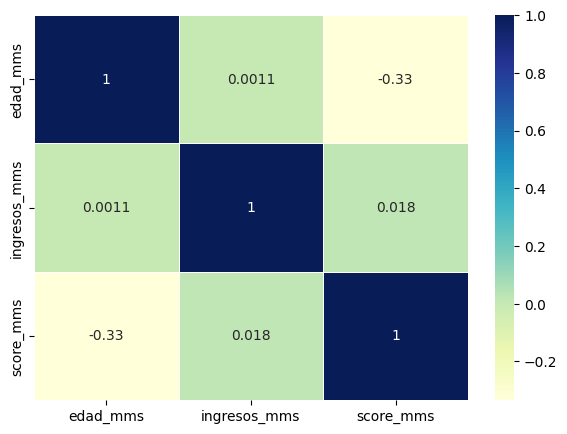

In [78]:
corrs = df_c[['edad_mms','ingresos_mms','score_mms']].corr() #Heatmap for numetrical columns
fig, ax = plt.subplots(figsize=(7,5))        

sns.heatmap(corrs,annot = True,ax=ax,linewidths=.6, cmap = 'YlGnBu');

In [95]:
from sklearn.impute import SimpleImputer
columns_to_impute = ['edad', 'ingresos', 'score']
df_sn = df[columns_to_impute]
imputer = SimpleImputer(strategy='mean')
df_sn = pd.DataFrame(imputer.fit_transform(df_sn), columns=columns_to_impute)

### PCA

[0.503 0.364 0.132]

[50.3 86.7 99.9]


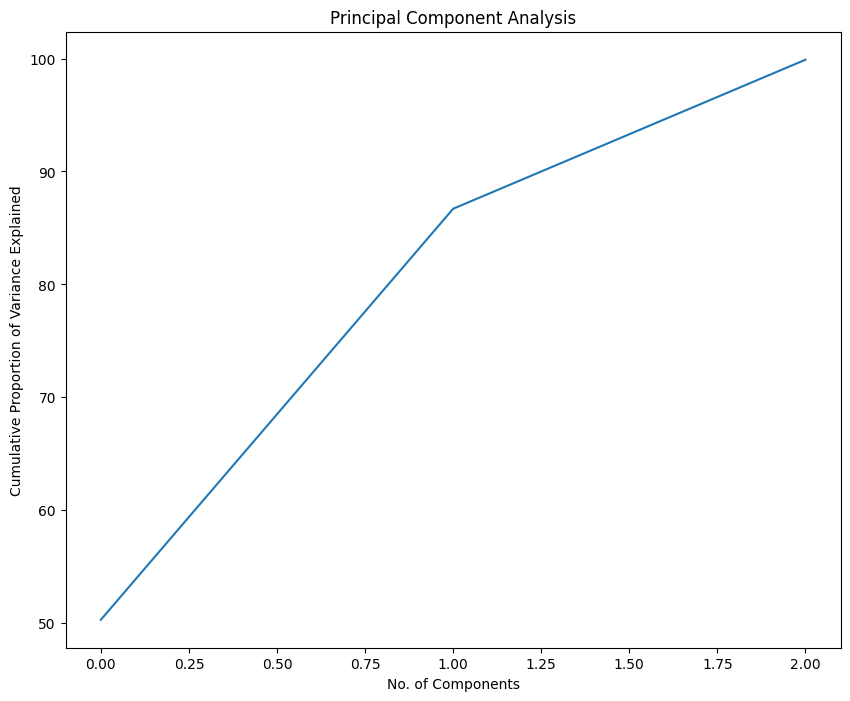

In [96]:
pca = PCA(n_components=df_sn.shape[1])
pca_model = pca.fit(df_sn)
var = pca_model.explained_variance_ratio_
print(np.around(var, 3))
print('')
principalComponents = pca_model.transform(df_sn)
#print(principalComponents[:,1])
cumulative_var = np.cumsum(np.around(var, 3)*100)
print(cumulative_var)

plt.figure(figsize=(10,8))
plt.plot(cumulative_var)
#plt.ylim(0,30)
plt.title("Principal Component Analysis")
plt.xlabel("No. of Components")
plt.ylabel("Cumulative Proportion of Variance Explained")
plt.show()

<Figure size 1200x800 with 0 Axes>

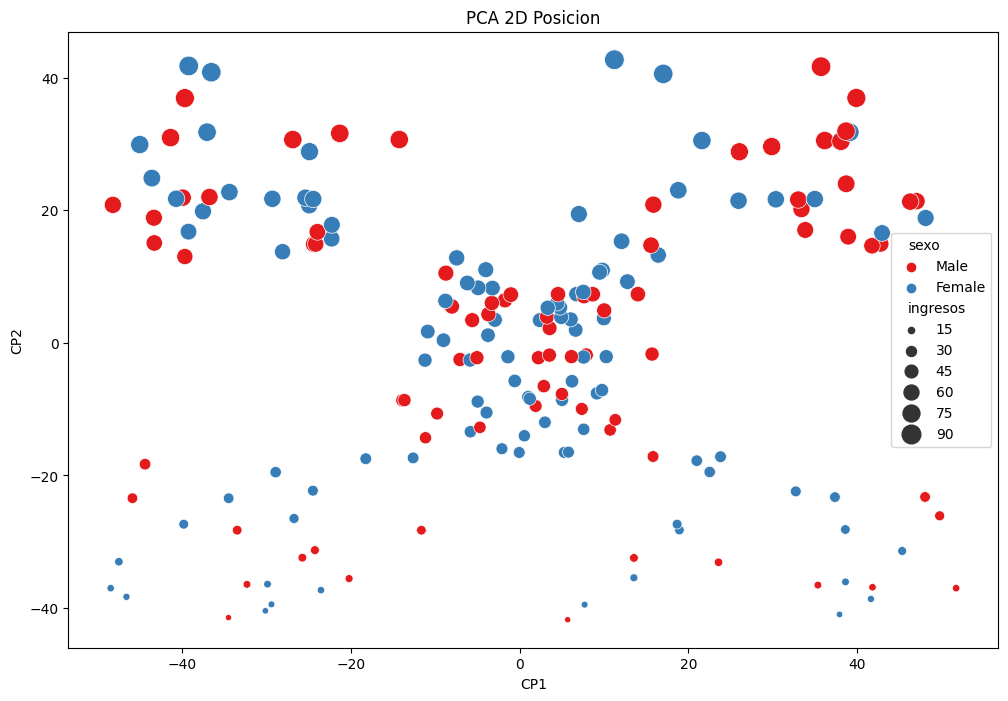

In [99]:
plt.figure(figsize=(12,8))

x=principalComponents[:, 0]
y=principalComponents[:, 1]

plt.figure(figsize=(12,8))
sns.scatterplot(data=df,x=x, y=y, hue=df.sexo,palette="Set1",size="ingresos",sizes=(20, 200))
plt.title('PCA 2D Posicion')
plt.xlabel('CP1')
plt.ylabel('CP2')
plt.show();

<Figure size 1200x800 with 0 Axes>

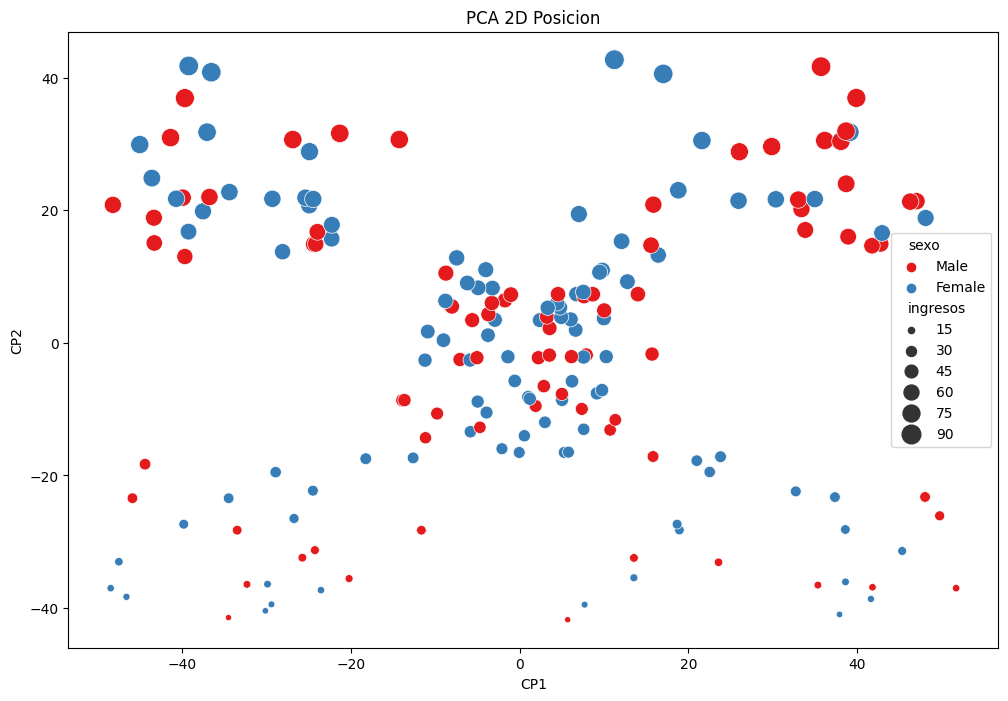

In [101]:
plt.figure(figsize=(12,8))

x=principalComponents[:, 0]
y=principalComponents[:, 1]

plt.figure(figsize=(12,8))
sns.scatterplot(data=df,x=x, y=y, hue=df.sexo,palette="Set1",size="ingresos",sizes=(20, 200))
plt.title('PCA 2D Posicion')
plt.xlabel('CP1')
plt.ylabel('CP2')
plt.show();

### Identificar la mejor solucion

#### Analizar las métricas

#### Analizar los gráficos